In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%pylab inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Populating the interactive namespace from numpy and matplotlib
./kaggle/input\polyai-ml-a20\data_test.npz
./kaggle/input\polyai-ml-a20\data_train.npz
./kaggle/input\polyai-ml-a20\sampleSubmission.csv


In [2]:
from tensorflow.keras.datasets import cifar100, cifar10

(train_data_DAE, train_labels), (test_data_DAE, test_labels) = cifar100.load_data(label_mode='fine')

train_clean_copy = train_data_DAE.astype('float32') / 255.
test_clean_copy = test_data_DAE.astype('float32') / 255.
train_data_clean = train_data_DAE.astype('float32') / 255.
test_data_clean = test_data_DAE.astype('float32') / 255.

(50000, 32, 32, 3)
(10000, 32, 32, 3)


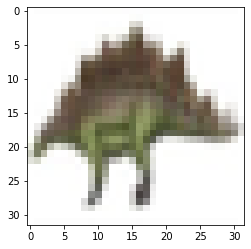

In [3]:
plt.imshow(train_clean_copy[1])
print(train_data_clean.shape)
print(test_data_clean.shape)

In [4]:
def add_noise(img):
    n = 1
    p = 0.78
    img = np.array(img)

    noise = np.random.binomial(1, 0.78, size=(len(img), len(img[0])))

    for i in range(len(noise)):
        for j in range(len(noise[i])):
            if noise[i,j] == 0:
                img[i,j] = (0.,0.,0.)
    return img

def add_noise_and_clip(data):
    data = np.array(data)
    for i in range(len(data)):
        data[i] = add_noise(data[i])
    return data

train_data_noisy = add_noise_and_clip(train_clean_copy)
test_data_noisy = add_noise_and_clip(test_clean_copy)

0.2216796875


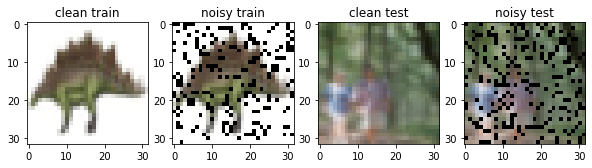

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(train_data_clean[1])
plt.title("clean train")
plt.subplot(1,4,2)
plt.imshow(train_data_noisy[1])
plt.title("noisy train")
plt.subplot(1,4,3)
plt.imshow(test_data_clean[1])
plt.title("clean test")
plt.subplot(1,4,4)
plt.imshow(test_data_noisy[1])
plt.title("noisy test")

count = 0
k=5
for i in range(len(train_data_noisy[k])):
    for j in range(len(train_data_noisy[k])):
        if np.all(train_data_noisy[k, i, j] == (0., 0., 0.)):
            count += 1
print(count / (32*32))

In [37]:
from tensorflow.keras import Model 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Flatten, Input, BatchNormalization, Dense, Add, Conv2DTranspose, Reshape, Softmax, Dropout
MINIBATCH_SIZE = 128

#Input 
input_img = Input(shape=(32, 32, 3))
#Encoder 
y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(input_img)
y = ReLU()(y)
y = BatchNormalization()(y)
y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
y = ReLU()(y)
y = BatchNormalization()(y)
y1 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y) # skip-1
y = ReLU()(y1)
y = BatchNormalization()(y)
y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = ReLU()(y)
y = BatchNormalization()(y)
y2 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)# skip-2
y = ReLU()(y2)
y = BatchNormalization()(y)
#Flattening for the bottleneck
vol = y.shape
x = Flatten()(y)
latent = Dense(128, activation='relu')(x) 

# Helper function to apply activation and batch normalization to the # output added with output of residual connection from the encoder
def lrelu_bn(inputs):
   lrelu = ReLU()(inputs)
   bn = BatchNormalization()(lrelu)
   return bn
#Decoder
y = Dense(np.prod(vol[1:]), activation='relu')(latent)
y = Reshape((vol[1], vol[2], vol[3]))(y)
y = Conv2DTranspose(256, (3,3), padding='same')(y)
y= Add()([y2, y]) # second skip connection added here
y = lrelu_bn(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = ReLU()(y)
y = BatchNormalization()(y)
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)
y= Add()([y1, y]) # first skip connection added here
y = lrelu_bn(y)
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
y = ReLU()(y)
y = BatchNormalization()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
y = ReLU()(y)
y = BatchNormalization()(y)
y = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

denoising_autoencoder = Model(input_img, y)
denoising_autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
denoising_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 32)   896         ['input_5[0][0]']                
                                                                                                  
 re_lu_17 (ReLU)                (None, 16, 16, 32)   0           ['conv2d_12[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 32)  128         ['re_lu_17[0][0]']               
 ormalization)                                                                              

In [7]:
checkpoint = ModelCheckpoint('dae_weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
denoising_autoencoder.fit(
    x=train_data_noisy,
    y=train_data_clean,
    batch_size=MINIBATCH_SIZE,
    epochs=50,
    validation_data=(test_data_noisy, test_data_clean),
    callbacks=[checkpoint]
)
denoising_autoencoder.save_weights(filepath="dae_weights.h5")

Epoch 1/50
391/391 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.6646
Epoch 00001: val_loss improved from inf to 0.00791, saving model to dae_weights.h5
391/391 [==============================] - 77s 189ms/step - loss: 0.0110 - accuracy: 0.6646 - val_loss: 0.0079 - val_accuracy: 0.7485
Epoch 2/50
391/391 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.7800
Epoch 00002: val_loss improved from 0.00791 to 0.00385, saving model to dae_weights.h5
391/391 [==============================] - 71s 180ms/step - loss: 0.0041 - accuracy: 0.7800 - val_loss: 0.0039 - val_accuracy: 0.7792
Epoch 3/50
391/391 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.7999
Epoch 00003: val_loss improved from 0.00385 to 0.00291, saving model to dae_weights.h5
391/391 [==============================] - 76s 195ms/step - loss: 0.0030 - accuracy: 0.7999 - val_loss: 0.0029 - val_accuracy: 0.8119
Epoch 4/50
391/391 [==============================] -

TypeError: save_weights() missing 1 required positional argument: 'filepath'

In [83]:
denoising_autoencoder.load_weights('dae_weights.h5')
test_data_denoised = denoising_autoencoder.predict(test_data_noisy)


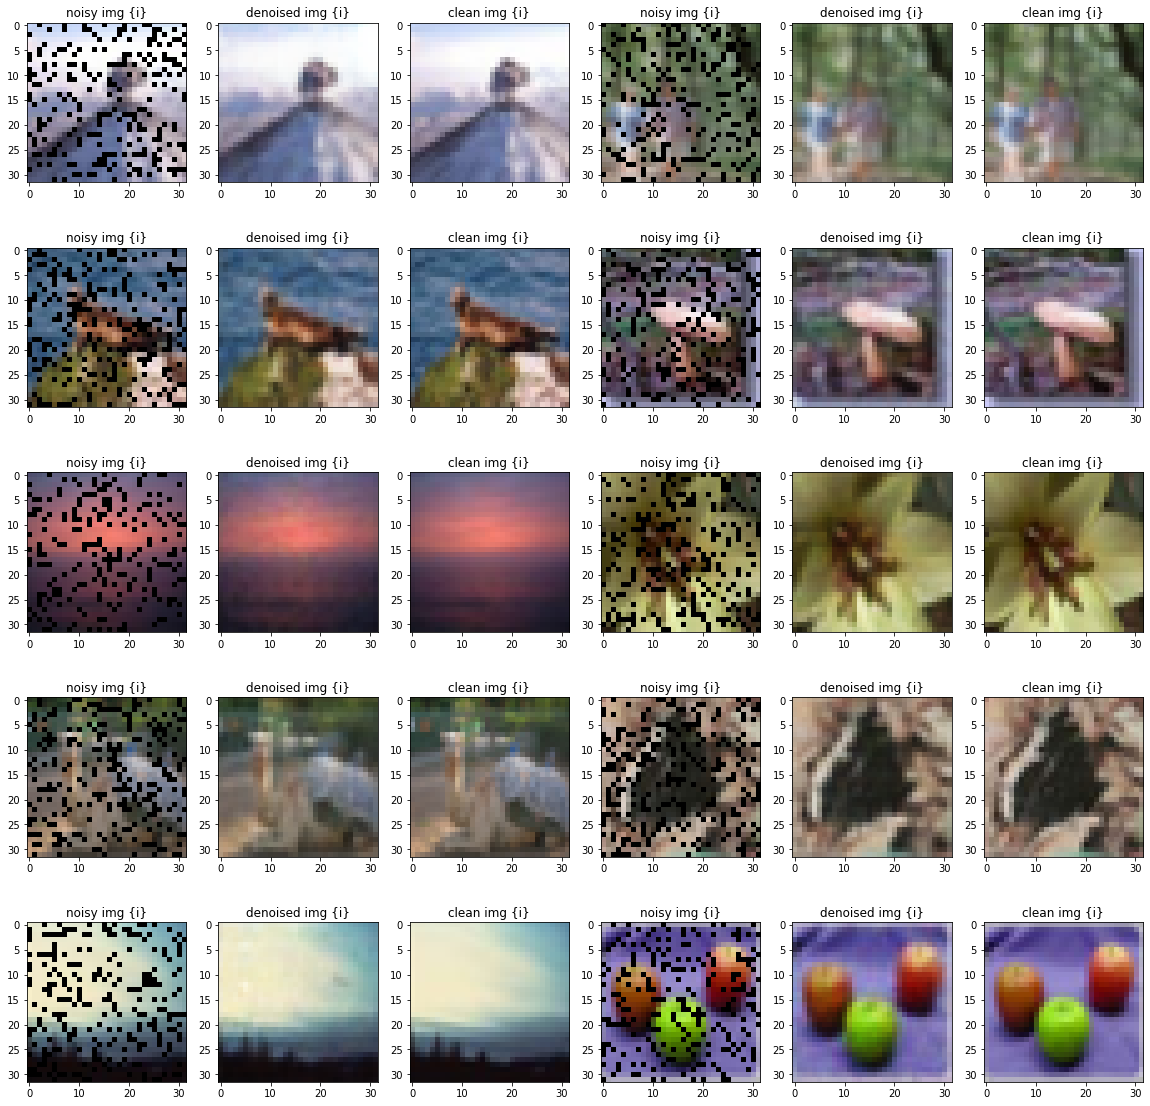

In [84]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,6,1 + i * 3)
    plt.imshow(test_data_noisy[i])
    plt.title("noisy img {i}")
    plt.subplot(5,6,2 + i * 3)
    plt.imshow(test_data_denoised[i])
    plt.title("denoised img {i}")
    plt.subplot(5,6,3 + i * 3)
    plt.imshow(test_data_clean[i])
    plt.title("clean img {i}")

In [125]:
data_train_file = np.load("./kaggle/input/polyai-ml-a20/data_train.npz")
data_test_file = np.load("./kaggle/input/polyai-ml-a20/data_test.npz")

In [126]:
print(data_train_file.files)
print(data_test_file.files)

['data', 'labels', 'metadata']
['data', 'metadata']


In [127]:
data_train_file['labels']
data_test_file['metadata']

array([b'aquatic_mammals', b'fish', b'flowers', b'food_containers',
       b'fruit_and_vegetables', b'household_electrical_devices',
       b'household_furniture', b'insects', b'large_carnivores',
       b'large_man-made_outdoor_things', b'large_natural_outdoor_scenes',
       b'large_omnivores_and_herbivores', b'medium_mammals',
       b'non-insect_invertebrates', b'people', b'reptiles',
       b'small_mammals', b'trees', b'vehicles_1', b'vehicles_2'],
      dtype='|S30')

In [128]:
images_train = data_train_file['data']
print(images_train.shape)
labels_train = data_train_file['labels']
labels_metadata_train = data_train_file['metadata'].astype(str)
images_test = data_test_file['data']
labels_metadata_test = data_test_file['metadata'].astype(str)
image0 = images_train[65]
label0 = labels_train[65]

(50000, 32, 32, 3)


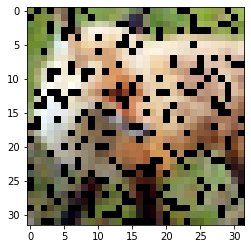

Class: 12
Name: medium_mammals


In [129]:
plt.imshow(image0)
plt.show()
print("Class:", label0)
print("Name:", labels_metadata_train[label0])
labels_train = to_categorical(labels_train)

In [130]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def normalize_imgs(array):
    return array.astype("float32") / 255.


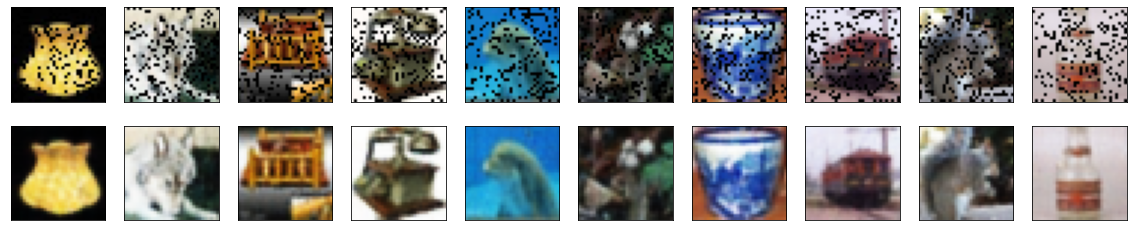

In [131]:
images_train = normalize_imgs(images_train)
images_test = normalize_imgs(images_test)

images_train_denoised = denoising_autoencoder.predict(images_train)
images_test_denoised = denoising_autoencoder.predict(images_test)
display(images_train, images_train_denoised)

#images_train_denoised = normalize_imgs(images_train_denoised)
#images_test_denoised = normalize_imgs(images_test_denoised)


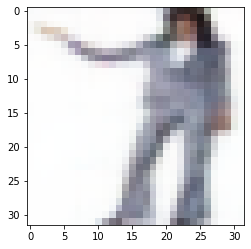

In [132]:
plt.imshow(images_train_denoised[0])

In [133]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import optimizers

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

num_classes = 20
weight_decay = 1e-4

input = Input((32,32,3))

images_train_denoised_copy = np.array(images_train_denoised)
images_test_denoised_copy = np.array(images_test_denoised)

images_train_denoised *= 255.
images_test_denoised *= 255.

mean = np.mean(images_train_denoised,axis=(0,1,2,3))
std = np.std(images_train_denoised,axis=(0,1,2,3))
images_train_denoised = (images_train_denoised-mean)/(std+1e-7)
images_test_denoised = (images_test_denoised-mean)/(std+1e-7)

x = Conv2D(32, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(input)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation="elu", padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(num_classes)(x)
x = Softmax()(x)

cnn = Model(input, x)
opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
cnn.compile(optimizer=opt_rms, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(images_train_denoised)

C:\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_74 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_75 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 16, 16, 32)       0  

In [145]:
checkpoint = ModelCheckpoint('cnn_weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
images_train_denoised0, images_train_denoised1 = images_train_denoised[:40000], images_train_denoised[40000:]
labels_train0, labels_train1 = labels_train[:40000], labels_train[40000:]
cnn.fit(
    datagen.flow(images_train_denoised0, labels_train0), batch_size=64,
    steps_per_epoch=images_train_denoised0.shape[0] // 64, 
    epochs=100,
    verbose=1,
    validation_data=(images_train_denoised1, labels_train1),
    callbacks=[checkpoint, LearningRateScheduler(lr_schedule)]
)
cnn.save_weights(filepath="cnn_weights.h5")

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 2.0795 - accuracy: 0.3830
Epoch 00001: val_loss improved from inf to 1.88751, saving model to cnn_weights.h5
625/625 [==============================] - 103s 159ms/step - loss: 2.0795 - accuracy: 0.3830 - val_loss: 1.8875 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 1.9957 - accuracy: 0.4096
Epoch 00002: val_loss did not improve from 1.88751
625/625 [==============================] - 100s 160ms/step - loss: 1.9957 - accuracy: 0.4096 - val_loss: 1.9264 - val_accuracy: 0.4436 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.4202
Epoch 00003: val_loss improved from 1.88751 to 1.78867, saving model to cnn_weights.h5
625/625 [==============================] - 99s 159ms/step - loss: 1.9506 - accuracy: 0.4202 - val_loss: 1.7887 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 4/100
625/625 [========================

flowers
people
vehicles_2
fish
large_man-made_outdoor_things
fruit_and_vegetables
vehicles_1
aquatic_mammals
vehicles_1
large_carnivores


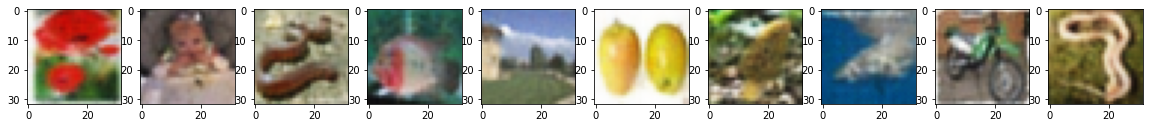

In [144]:
cnn.load_weights('cnn_weights.h5')
plt.figure(figsize=(20,20))
for j in range(10):
    plt.subplot(1,10,j + 1)
    plt.imshow(images_test_denoised_copy[j])
labels = np.array(str)
predictions = cnn.predict(images_test_denoised)
for i in range(10):
    print(labels_metadata_train[np.argmax(predictions[i])])

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100, cifar10